# E4 and Hexoskin Processing Pipeline
Written by Arturo Salinas for the University of Connecticut Human Factors IO Labrotory under the guidance of PI Dr. Insoo Kim

### Import Packages and Set Session Directory

Install the required packages:
Utilize conda to import the enviroment.yml.

In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import neurokit2 as nk
from IPython.display import display, HTML
from datetime import datetime, timezone
from pyedflib.highlevel import read_edf
from wrangle import *
# from time_loader import *

Checks for the correct data in selected directory

In [92]:
required_files = [
        'CSV.csv',
        'EDF.edf',
        'BVP.csv',
        'EDA.csv',
        'ACC.csv',
        'TEMP.csv',
        'tags.csv',
        'IBI.csv'
    ]

dataDirectory = "/home/art/SignalProcessing/Sessions/P023/"
participant_id = int(23)
events = "/home/art/SignalProcessing/Sessions/time_sheet1.csv"

print("Current directory is:", dataDirectory)
missing_files = [f for f in required_files if f not in os.listdir(dataDirectory)]
existing_files = [f for f in os.listdir(dataDirectory) if f in required_files]
if participant_id:
    print(f"\nChecking files for participant: {participant_id}")
    print(f"Directory being checked: {dataDirectory}")
    if not missing_files:
        print("✓ All required files are present!")
    else:
        print("\nMissing files:")
        for file in missing_files:
            print(f"✗ {file}")
        print(f"\nFound files:")
        for file in existing_files:
            print(f"• {file}")

Current directory is: /home/art/SignalProcessing/Sessions/P023/

Checking files for participant: 23
Directory being checked: /home/art/SignalProcessing/Sessions/P023/
✓ All required files are present!


# Load Hexoskin Data

In [93]:
hexcsv = os.path.join(dataDirectory, "CSV.csv")
hexedf = os.path.join(dataDirectory, "EDF.edf")

hextable = pd.read_csv(hexcsv)
#hextable = hextable.iloc[:, [0, 1, 2, 4, 5, 6]]                            # Keeps time, breathing, minute vent, act, HR, and cadence -AJS
#hextable = hextable.iloc[1:-1, :].reset_index(drop=True)                   # Drops first and last rows, resets index -AJS
time_start_hexo = hextable.iloc[0, 0] / 256                                # Gets start time in seconds * ( 1 / 256 as that is the sampling rate of time in csv) -AJS
startTime_hexo = datetime.fromtimestamp(time_start_hexo, tz=timezone.utc)  # Converts timestamp to datetime -AJS

signals, signal_headers, header = read_edf(hexedf)
signal_names = [header['label'] for header in signal_headers]
sampling_rates = [header['sample_frequency'] for header in signal_headers]

signal_data = {}
for i, signal_name in enumerate(signal_names):
  signal_data[signal_name] = signals[i]


max_sample_rate = max(sampling_rates)
max_sample_rate_index = sampling_rates.index(max_sample_rate)
max_sample_rate_signal_name = signal_names[max_sample_rate_index]

num_samples_max = len(signal_data[max_sample_rate_signal_name])
total_time = num_samples_max / 256
print(total_time, "seconds of Data has been loaded")
time_index = pd.date_range(start=startTime_hexo, periods=num_samples_max, freq=f'{1000/max_sample_rate}ms')

combined_raw_hexo_df = pd.DataFrame(index=time_index)

for signal_name, signal_values in signal_data.items():
  
    sample_rate = sampling_rates[signal_names.index(signal_name)]

    temp_df = pd.DataFrame({signal_name: signal_values})

    temp_time_index = pd.date_range(start = startTime_hexo, periods=len(signal_values), freq=f'{1000/sample_rate}ms')
    temp_df.index = temp_time_index

    combined_raw_hexo_df = combined_raw_hexo_df.join(temp_df, how = 'left')

ECG = signals[0] # 256 Hz
HR = signals[1] # 1 Hz
BR = signals[2] # 1 Hz

RespT = signals[3] # 128 Hz
RespA = signals[4] # 128 Hz

AccX = signals[11] # 64 Hz
AccY = signals[12] # 64 Hz
AccZ = signals[13] # 64 Hz



Resp = 13.28 * ((0.75 * RespT) + (0.25 * RespA))     # see hexoskin documentation for how this is calculated
ACC_Hex = np.sqrt((AccX**2) + (AccY**2) + (AccZ**2)) # magnitude calculation


7017.0 seconds of Data has been loaded


## Initial Inspection of Hexoskin Data

In [94]:
# print("EDF Signal Data:")
# for i, signal in enumerate(signals):
#    signal_header = signal_headers[i]
#    channel_name = signal_header['label']
#    sampling_rate = signal_header['sample_frequency']
#    start_time_offset = signal_header.get('start_time', 0) 

#    time_vector = np.array([start_time_offset + (sample_index / sampling_rate) for sample_index in range(len(signal[:3]))])

#    print(f"\nSignal {i}: {channel_name}")
#    print(f"  Sampling Rate: {sampling_rate} Hz")
    
#    print("  Timestamp \t | Data")
#    for j in range(len(signal[:3])):
#    print(f"{time_vector[j]:.4f} s \t | {signal[j]}")

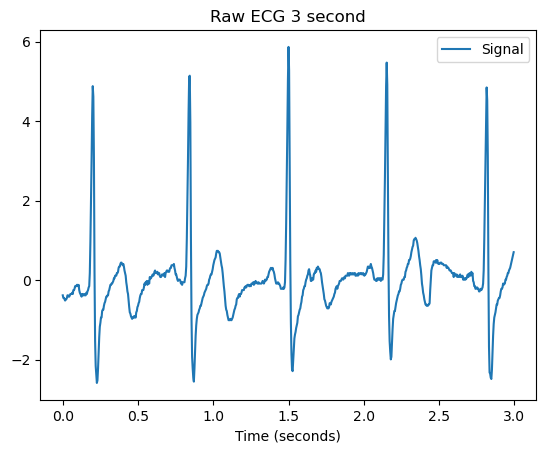

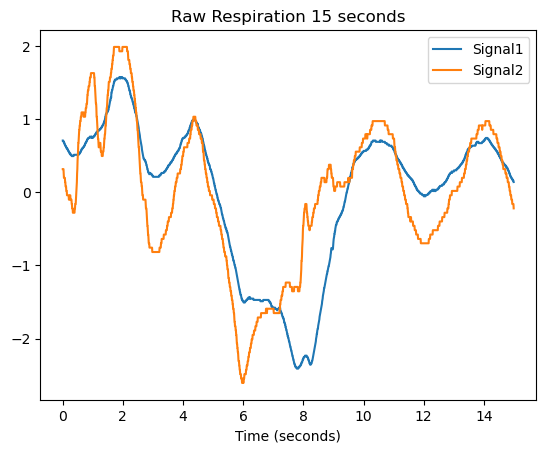

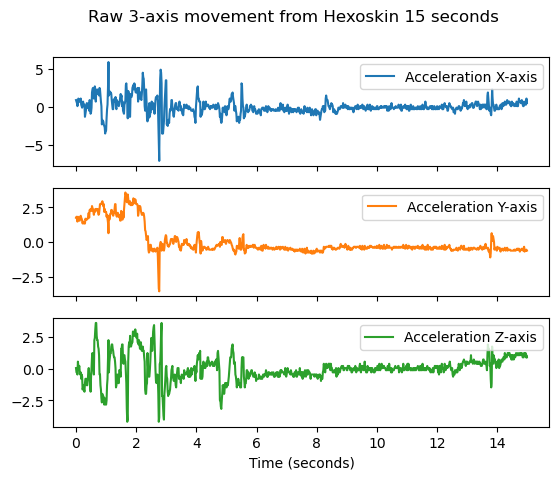

In [95]:
nk.signal_plot(ECG[460800:461568], sampling_rate=256, standardize=True) # ~ 3 second window -AJS
plt.title("Raw ECG 3 second")
nk.signal_plot([RespT[230400:232320], RespA[230400:232320]], sampling_rate=128, standardize=True) # ~ 15 second window -AJS
plt.title("Raw Respiration 15 seconds")
nk.signal_plot([AccX[115200:116160], AccY[115200:116160], AccZ[115200:116160]], sampling_rate=64,
               subplots=True, standardize=True,
               labels=["Acceleration X-axis", "Acceleration Y-axis", "Acceleration Z-axis"]) # ~ 15 second window -AJS
plt.suptitle("Raw 3-axis movement from Hexoskin 15 seconds");

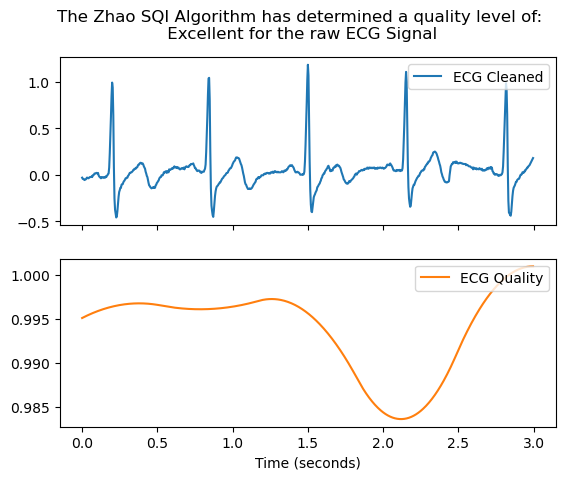

In [96]:
ecg_quality = nk.ecg_quality(ECG, sampling_rate=256, method="averageQRS")

nk.signal_plot(
    [ECG[460800:461568], ecg_quality[460800:461568]],
    sampling_rate=256,
    subplots=True,
    labels=["ECG Cleaned", "ECG Quality"],
    standardize=False
)
plt.suptitle(f"The Zhao SQI Algorithm has determined a quality level of:\n {nk.ecg_quality(ECG, sampling_rate=256, method='zhao2018', approach='fuzzy')} for the raw ECG Signal");

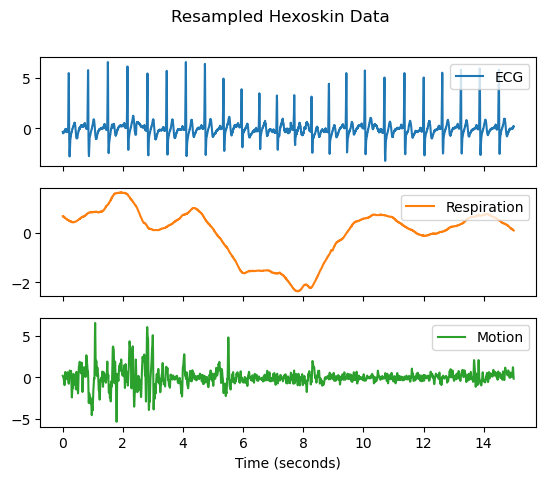

In [97]:
TARGET_SAMPLE_RATE = 256 # just in case we need to downsample instead later... -AJS
fs = TARGET_SAMPLE_RATE
ecg_up = nk.signal_resample(ECG, sampling_rate=256, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT') # already 256 -AJS

RespT_up = nk.signal_resample(RespT, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')
RespA_up = nk.signal_resample(RespA, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')
Resp_up = nk.signal_resample(Resp, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

hex_accx_up = nk.signal_resample(AccX, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_accy_up = nk.signal_resample(AccY, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_accz_up = nk.signal_resample(AccZ, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_motion_up = nk.signal_resample(ACC_Hex, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

nk.signal_plot([ecg_up[460800:464640], Resp_up[460800:464640], hex_motion_up[460800:464640]], sampling_rate=256, subplots=True, standardize=True, labels=['ECG', 'Respiration', 'Motion'])
plt.suptitle("Resampled Hexoskin Data");

Pack the Hexoskin Signals

In [98]:
hexo_np = np.column_stack([ecg_up, RespT_up, RespA_up, Resp_up, hex_accx_up, hex_accy_up, hex_accz_up, hex_motion_up])

time_index_hexo = pd.date_range(
    start=startTime_hexo,
    periods=len(hexo_np),
    freq=pd.Timedelta(1/fs, unit='s')
)

comb_hexo = pd.DataFrame(
    hexo_np,
    index=time_index_hexo,
    columns=["ECG","Thoratic Respiration", "Abdominal Respiration", "Combined Respiration", "ACC X", "ACC Y", "ACC Z", "Hexoskin Motion"]
)

display(comb_hexo.head())

,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2024-11-21 18:16:39+00:00,8.953637,-2.017401e-11,-1.061790e-11,-1.783807e-10,1.085890,-0.156297,0.456984,1.188453
2024-11-21 18:16:39.003906250+00:00,17.504031,-6.625167e+01,-1.368211e+02,-1.114113e+03,1.078078,-0.151414,0.475539,1.310896
2024-11-21 18:16:39.007812500+00:00,17.504031,7.963477e-12,3.716269e-12,1.189213e-10,1.070265,-0.146531,0.494094,1.322453
2024-11-21 18:16:39.011718750+00:00,17.504031,1.586583e+02,2.352863e+02,2.361387e+03,1.062453,-0.141648,0.512648,1.264133
2024-11-21 18:16:39.015625+00:00,17.504031,2.548316e-11,7.432567e-12,-4.753758e-16,1.054640,-0.136766,0.531203,1.188759


# Load E4 Data
Loads the data from the E4 CSV's into the notebook environment

In [99]:
BVPe4   = os.path.join(dataDirectory, "BVP.csv")
EDAe4   = os.path.join(dataDirectory, "EDA.csv")
ACCe4   = os.path.join(dataDirectory, "ACC.csv")
Tempe4  = os.path.join(dataDirectory, "TEMP.csv")
HRe4    = os.path.join(dataDirectory, 'HR.csv')   # pre calculated from IBI on empatica side -AJS
IBI_path = os.path.join(dataDirectory, "IBI.csv") # might need this later, but I want to use the hexo ecg instead -AJS   
    
BVP_raw = read_e4_csv(BVPe4, ['bvp']) # 64 Hz
EDA_raw = read_e4_csv(EDAe4, ['eda']) # 4 Hz
ACC_raw = read_e4_csv(ACCe4, ['acc_x', 'acc_y', 'acc_z']) # 32 Hz
Temp_raw = read_e4_csv(Tempe4, ['temp']) # 64 Hz
HRe4_raw = read_e4_csv(HRe4, ['hr_e4']) # 1 Hz
IBIe4 = read_ibi_file(IBI_path) # peak to peak distances from e4 precalced, scaled * 1000 -AJS

combined_raw_e4 = pd.concat([BVP_raw, EDA_raw, ACC_raw, Temp_raw, HRe4_raw, IBIe4], axis=1)

### Initial Inspection of E4 Data

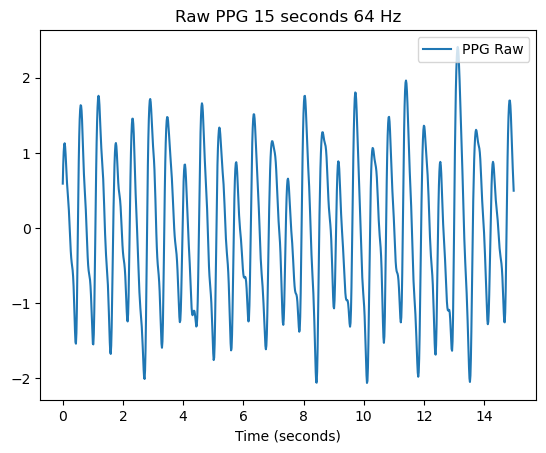

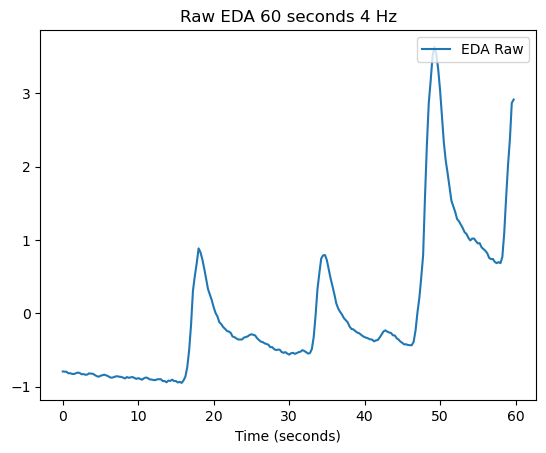

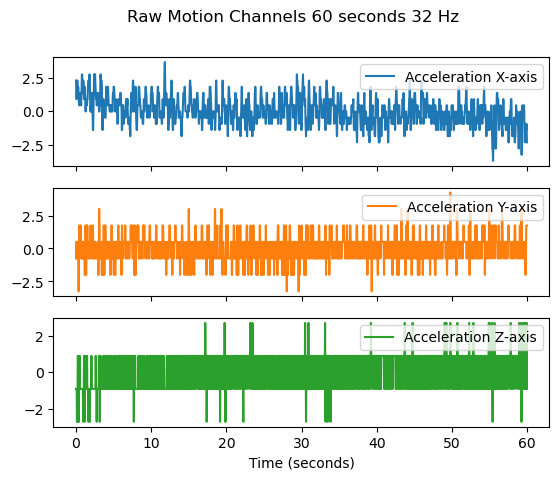

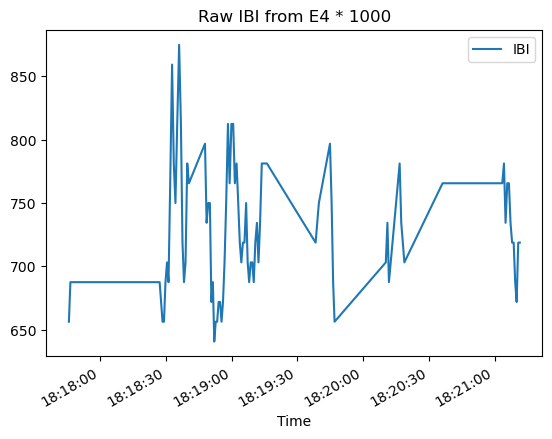

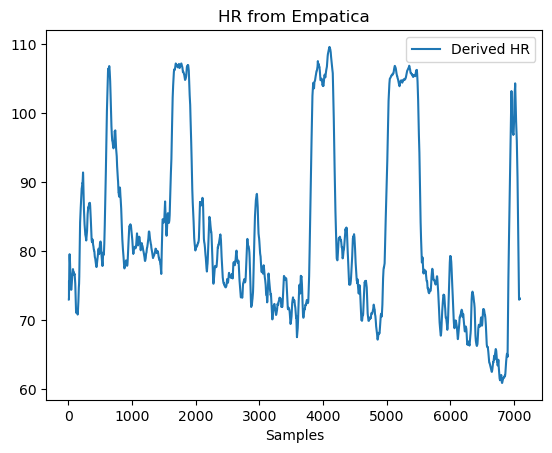

In [100]:
BVP = BVP_raw['bvp'].values
EDA = EDA_raw['eda'].values
acc_x = ACC_raw['acc_x'].values
acc_y = ACC_raw['acc_y'].values
acc_z = ACC_raw['acc_z'].values
Temp = Temp_raw['temp'].values

time_diff = (HRe4_raw.index[0] - BVP_raw.index[0]).total_seconds()

if time_diff > 0:
    buffer = pd.Series([HRe4_raw.iloc[0]] * int(time_diff), index=pd.date_range(
        start=HRe4_raw.index[0] - pd.Timedelta(seconds=time_diff),
        periods=int(time_diff),
        freq="1s"
    ))
    HRe4_raw = pd.concat([buffer, HRe4_raw])

hr_e4 = HRe4_raw['hr_e4'].values

nk.signal_plot(BVP[115200:116160], sampling_rate=64, standardize=True, labels=['PPG Raw']) # ~ 15 second window -AJS
plt.title("Raw PPG 15 seconds 64 Hz")
nk.signal_plot(EDA[7200:7440], sampling_rate=4, standardize=True, labels=['EDA Raw']) # ~ 60 second window -AJS
plt.title("Raw EDA 60 seconds 4 Hz")
nk.signal_plot([acc_x[57600:59520], acc_y[57600:59520], acc_z[57600:59520]], sampling_rate=32,
               subplots=True, standardize=True, 
               labels=["Acceleration X-axis", "Acceleration Y-axis", "Acceleration Z-axis"]) # ~ 15 second window -AJS
plt.suptitle('Raw Motion Channels 60 seconds 32 Hz');
nk.signal_plot(IBIe4[10:100], labels=['IBI'])
plt.title("Raw IBI from E4 * 1000");

nk.signal_plot(hr_e4, labels=['Derived HR'])
plt.title("HR from Empatica");

In [101]:
#signals, info = nk.eda_process(EDA[7200:7440], sampling_rate=4)
#nk.eda_plot(signals, info)

In [102]:
#acc_x_filt = nk.signal_filter(acc_x, sampling_rate=32, lowcut=0.25, highcut=0.5, method='butterworth', order=3)
#acc_y_filt = nk.signal_filter(acc_y, sampling_rate=32, lowcut=0.25, highcut=0.5, method='butterworth', order=3)
#acc_z_filt = nk.signal_filter(acc_z, sampling_rate=32, lowcut=0.25, highcut=0.5, method='butterworth', order=3)

#nk.signal_plot([acc_x[57600:59520], acc_x_filt[57600:59520]], sampling_rate=32,
#               subplots=False, standardize=True,
#               labels=["Raw X-axis", "Filtered X-axis"])

 # magnitude calculation

# ACC_E4_clean = nk.signal_filter(ACC_E4, sampling_rate=32, highcut=0.5, method='butterworth', order=3)
#nk.signal_plot([ACC_E4[57600:59520], ACC_E4_clean[57600:59520]], sampling_rate=32, labels=['Raw E4 Motion', 'Filtered E4 Motion'], standardize=True)
# plt.suptitle("Motion from E4");

Resample E4 signals to 256
BVP => 64->256 => factor=4, EDA => 4->256 =>64, ACC =>32->256 =>8, Temp =>4->256 =>64

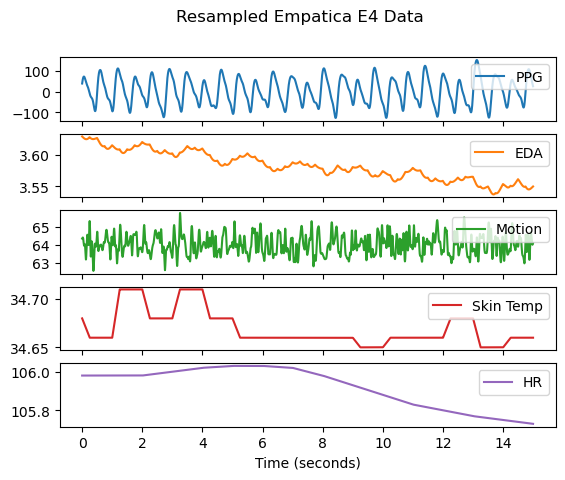

In [103]:
ppg_up = nk.signal_resample(BVP, sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

#time_bvp = np.arange(len(BVP)) / 64
#time_ppg = np.arange(len(ppg_up)) / 256

#plt.figure()
#plt.plot(time_bvp, BVP, label='Original PPG')
#plt.plot(time_ppg, ppg_up, label='Resampled')
#plt.legend()
#plt.show
eda_up = nk.signal_resample(EDA, desired_length=len(ppg_up), sampling_rate=4, desired_sampling_rate=TARGET_SAMPLE_RATE, method='poly')

#time_eda = np.arange(len(EDA)) / 4
#time_eda_up = np.arange(len(eda_up)) / 256

#plt.figure()
#plt.plot(time_eda, EDA, label='original eda')
#plt.plot(time_eda_up, eda_up, label='upsampled eda')
#plt.legend()
#plt.show

e4_hr_up = nk.signal_resample(hr_e4, desired_length=len(ppg_up), sampling_rate=1, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')

ACC_E4_raw = np.sqrt((acc_x**2) + (acc_y**2) + (acc_z**2))
e4_accx_up = nk.signal_resample(acc_x, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')
e4_accy_up = nk.signal_resample(acc_y, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')
e4_accz_up = nk.signal_resample(acc_z, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')
e4_motion_up = nk.signal_resample(ACC_E4_raw, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')

temp_up = nk.signal_resample(Temp, desired_length=len(ppg_up), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')

nk.signal_plot([ppg_up[460800:464640], eda_up[460800:464640], e4_motion_up[460800:464640], temp_up[460800:464640], e4_hr_up[460800:464640]], sampling_rate=256, subplots=True, standardize=False, labels=['PPG', 'EDA', 'Motion', 'Skin Temp', 'HR'])
plt.suptitle("Resampled Empatica E4 Data");

Pack the E4 Signals

In [104]:
e4_np = np.column_stack([ppg_up, eda_up, e4_accx_up, e4_accy_up, e4_accz_up, e4_motion_up, temp_up, e4_hr_up])
startTime_E4 = BVP_raw.index[0] # Highest resolution start time -AJS

time_index_e4 = pd.date_range(
    start=startTime_E4,
    periods=len(e4_np),
    freq=pd.Timedelta(1/fs, unit='s')
)

comb_e4 = pd.DataFrame(
    e4_np,
    index=time_index_e4,
    columns=["PPG", "EDA", "E4 ACC X", "E4 ACC Y", "E4 ACC Z", "Motion E4", "Skin Temp", "Heart Rate"]
)

# Data Alignment

In [105]:
time_data = load_event_data(events)
participant_events = select_participant(time_data, participant_id)
times, utc_times = time_extract(participant_events)

In [106]:
utc_times_df = pd.DataFrame(utc_times)
start_time = pd.to_datetime(utc_times_df['survey_start'].iloc[0]).tz_localize('UTC')
end_time = pd.to_datetime(utc_times_df['recovery_end'].iloc[0]).tz_localize('UTC')

exclude_columns = [
    "date",
    "start_time",
    "end_time",
    "participant_id",
    "total_time",
    "experimental_time",
    "arrival_time"
]

for column in utc_times_df.columns:
    if column not in exclude_columns:
        utc_times_df[column] = pd.to_datetime(utc_times_df[column]).dt.tz_localize('UTC')
        
time_periods = [
    {"name": "survey", "start": utc_times_df['survey_start'].iloc[0], "end": utc_times_df['survey_end'].iloc[0]},
    {"name": "cycle_cal", "start": utc_times_df['cycle_cal_start'].iloc[0], "end": utc_times_df['cycle_cal_end'].iloc[0]},
    {"name": "matb_train", "start": utc_times_df['matb_train_start'].iloc[0], "end": utc_times_df['matb_train_end'].iloc[0]},
    {"name": "cycle", "start": utc_times_df['cycle_start'].iloc[0], "end": utc_times_df['cycle_end'].iloc[0]},
    {"name": "rest_1", "start": utc_times_df['rest_1_start'].iloc[0], "end": utc_times_df['rest_1_end'].iloc[0]},
    {"name": "baseline", "start": utc_times_df['base_start'].iloc[0], "end": utc_times_df['base_end'].iloc[0]},
    {"name": "trial_1", "start": utc_times_df['trial_1_start'].iloc[0], "end": utc_times_df['trial_1_end'].iloc[0]},
    {"name": "rest_2", "start": utc_times_df['rest_2_start'].iloc[0], "end": utc_times_df['rest_2_end'].iloc[0]},
    {"name": "trial_2", "start": utc_times_df['trial_2_start'].iloc[0], "end": utc_times_df['trial_2_end'].iloc[0]},
    {"name": "recovery", "start": utc_times_df['recovery_start'].iloc[0], "end": utc_times_df['recovery_end'].iloc[0]},
    {"name": "debrief", "start": utc_times_df['debrief_start'].iloc[0], "end": utc_times_df['debrief_end'].iloc[0]}
]

display(comb_e4.head())
display(comb_hexo.head())
display(comb_e4.tail())
display(comb_hexo.tail())

,PPG,EDA,E4 ACC X,E4 ACC Y,E4 ACC Z,Motion E4,Skin Temp,Heart Rate
2024-11-21 18:15:07+00:00,-4.002863e-14,1.124587e-16,-42.0,18.0,47.0,65.551506,32.16,NaN
2024-11-21 18:15:07.003906250+00:00,1.752020e+01,7.481957e-03,-42.0,18.0,47.0,65.543940,32.16,NaN
2024-11-21 18:15:07.007812500+00:00,1.991484e+01,1.526741e-02,-42.0,18.0,47.0,65.491618,32.16,NaN
2024-11-21 18:15:07.011718750+00:00,1.172285e+01,2.335447e-02,-43.0,18.0,46.0,65.350107,32.16,NaN
2024-11-21 18:15:07.015625+00:00,-5.029238e-14,3.174084e-02,-43.0,17.0,45.0,65.074971,32.16,NaN


,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2024-11-21 18:16:39+00:00,8.953637,-2.017401e-11,-1.061790e-11,-1.783807e-10,1.085890,-0.156297,0.456984,1.188453
2024-11-21 18:16:39.003906250+00:00,17.504031,-6.625167e+01,-1.368211e+02,-1.114113e+03,1.078078,-0.151414,0.475539,1.310896
2024-11-21 18:16:39.007812500+00:00,17.504031,7.963477e-12,3.716269e-12,1.189213e-10,1.070265,-0.146531,0.494094,1.322453
2024-11-21 18:16:39.011718750+00:00,17.504031,1.586583e+02,2.352863e+02,2.361387e+03,1.062453,-0.141648,0.512648,1.264133
2024-11-21 18:16:39.015625+00:00,17.504031,2.548316e-11,7.432567e-12,-4.753758e-16,1.054640,-0.136766,0.531203,1.188759


,PPG,EDA,E4 ACC X,E4 ACC Y,E4 ACC Z,Motion E4,Skin Temp,Heart Rate
2024-11-21 20:13:15.964843750+00:00,-172.635082,0.107408,-14.0,-11.0,54.0,55.949460,34.11,73.1
2024-11-21 20:13:15.968750+00:00,-151.880000,0.084613,-13.0,-11.0,53.0,54.817057,34.11,73.1
2024-11-21 20:13:15.972656250+00:00,-117.177693,0.062459,-13.0,-12.0,51.0,53.806121,34.11,73.1
2024-11-21 20:13:15.976562500+00:00,-74.388638,0.040961,-12.0,-12.0,50.0,53.079869,34.11,73.1
2024-11-21 20:13:15.980468750+00:00,-32.421594,0.020136,-12.0,-12.0,50.0,52.801515,34.11,73.1


,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2024-11-21 20:13:35.980468750+00:00,-8.70395,6.882780e+00,5.465491e+01,2.500068e+02,-0.000047,-0.000047,-0.000047,-0.161461
2024-11-21 20:13:35.984375+00:00,-8.70395,-9.556348e-12,-9.025215e-12,8.494273e-11,-0.000047,-0.000047,-0.000047,0.000081
2024-11-21 20:13:35.988281250+00:00,-8.70395,-1.488966e+01,-6.903112e+01,-3.774843e+02,-0.000047,-0.000047,-0.000047,0.280239
2024-11-21 20:13:35.992187500+00:00,-8.70395,2.973025e-11,4.247207e-12,2.548302e-10,-0.000047,-0.000047,-0.000047,0.621804
2024-11-21 20:13:35.996093750+00:00,-8.70395,3.091142e+01,9.276332e+01,6.158520e+02,-0.000047,-0.000047,-0.000047,0.947256


In [107]:
#end_time = '2024-11-06 18:21:16.964843750+00:00'
frequency = f"{1000000000 / 256}ns"
experiment_time_index = pd.date_range(start=start_time, end=end_time, freq=frequency)

aligned_e4 = comb_e4.reindex(experiment_time_index)
aligned_raw_e4_df = combined_raw_e4.reindex(experiment_time_index)
aligned_hexo = comb_hexo.reindex(experiment_time_index)
aligned_raw_hexo_df = combined_raw_hexo_df.reindex(experiment_time_index)
# aligned_ibi = IBIe4.reindex(experiment_time_index)

combined_df = pd.concat([aligned_e4, aligned_hexo], axis=1)
combined_raw_df = pd.concat([aligned_raw_e4_df, aligned_raw_hexo_df], axis=1)

combined_raw_df.drop(columns=['53:cadence', '98:SP', '99:SP_adjusted', '1000:HR_q', '1001:BR_q'], inplace=True)

new_columns = {
    'bvp': 'bvp_e4',
    'eda': 'eda_e4',
    'acc_x': 'acc_x_e4',
    'acc_y': 'acc_y_e4',
    'acc_z': 'acc_z_e4',
    'temp': 'temp_e4',
    'hr_e4': 'hr_e4',
    'ibi': 'ibi_e4',
    '4113:ECG_I': 'ECG_I_hex',
    '19:heart_rate': 'heart_rate_hex',
    '33:breathing_rat': 'breathing_rat_hex',
    '4129:resp_thorac': 'resp_thorac_hex',
    '4130:resp_abdomi': 'resp_abdomi_hex',
    '36:MV': 'MV_hex',
    '37:TV': 'TV_hex',
    '38:MV_adjusted': 'MV_adjusted_hex',
    '39:TV_adjusted': 'TV_adjusted_hex',
    '42:energy_miffli': 'energy_miffli_hex',
    '49:activity': 'activity_hex',
    '4145:accel_X': 'accel_X_hex',
    '4146:accel_Y': 'accel_Y_hex',
    '4147:accel_Z': 'accel_Z_hex',
    '338:RESP_TMPR': 'RESP_TMPR_hex'
}

combined_raw_df.rename(columns=new_columns, inplace=True)
display(combined_df.head())
time_periods_df = pd.DataFrame(time_periods)
time_periods_df['duration_minutes'] = (time_periods_df['end'] - time_periods_df['start']).dt.total_seconds() / 60

display(time_periods_df)

if (time_periods_df['duration_minutes'] < 0).any() or (time_periods_df['duration_minutes'] > 30).any():
    print('')
    print('')
    print(f'Possible Error in Timing Data Detected!!!!')
    print(f'Double check the experimental timing excel file for Participant {participant_id}.')
    print('')
    print('')


,PPG,EDA,E4 ACC X,E4 ACC Y,E4 ACC Z,Motion E4,Skin Temp,Heart Rate,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2024-11-21 18:21:05+00:00,-38.350000,3.865511,58.0,11.0,-17.0,61.411640,33.15,83.569811,0.051244,22184.000000,14654.000000,269603.920000,0.371047,-0.851609,-0.269578,0.967257
2024-11-21 18:21:05.003906250+00:00,-39.922056,3.866292,58.0,11.0,-17.0,61.576432,33.15,83.568873,0.051244,22183.845228,14653.966889,269602.268544,0.371047,-0.849656,-0.267625,0.964483
2024-11-21 18:21:05.007812500+00:00,-41.507441,3.867068,58.0,11.0,-18.0,61.798534,33.15,83.567936,0.064044,22184.000000,14654.000000,269603.920000,0.371047,-0.847703,-0.265672,0.961551
2024-11-21 18:21:05.011718750+00:00,-43.087120,3.867841,58.0,12.0,-18.0,62.077087,33.15,83.566998,0.057644,22184.526537,14654.030597,269609.265890,0.371047,-0.845750,-0.263719,0.959252
2024-11-21 18:21:05.015625+00:00,-44.640000,3.868608,58.0,12.0,-19.0,62.411228,33.15,83.566061,0.070444,22185.000000,14654.000000,269613.880000,0.371047,-0.843797,-0.261766,0.958222


,name,start,end,duration_minutes
0,survey,2024-11-21 18:21:05+00:00,2024-11-21 18:23:08+00:00,2.050000
1,cycle_cal,2024-11-21 18:23:50+00:00,2024-11-21 18:26:50+00:00,3.000000
2,matb_train,2024-11-21 18:27:04+00:00,2024-11-21 18:39:15+00:00,12.183333
3,cycle,2024-11-21 18:41:09+00:00,2024-11-21 18:46:09+00:00,5.000000
4,rest_1,2024-11-21 18:49:00+00:00,2024-11-21 18:59:00+00:00,10.000000
5,baseline,2024-11-21 18:59:45+00:00,2024-11-21 19:09:22+00:00,9.616667
6,trial_1,2024-11-21 19:15:47+00:00,2024-11-21 19:23:47+00:00,8.000000
7,rest_2,2024-11-21 19:27:00+00:00,2024-11-21 19:35:00+00:00,8.000000
8,trial_2,2024-11-21 19:37:47+00:00,2024-11-21 19:45:47+00:00,8.000000
9,recovery,2024-11-21 19:49:30+00:00,2024-11-21 19:49:30+00:00,0.000000


## Unified Data Plots

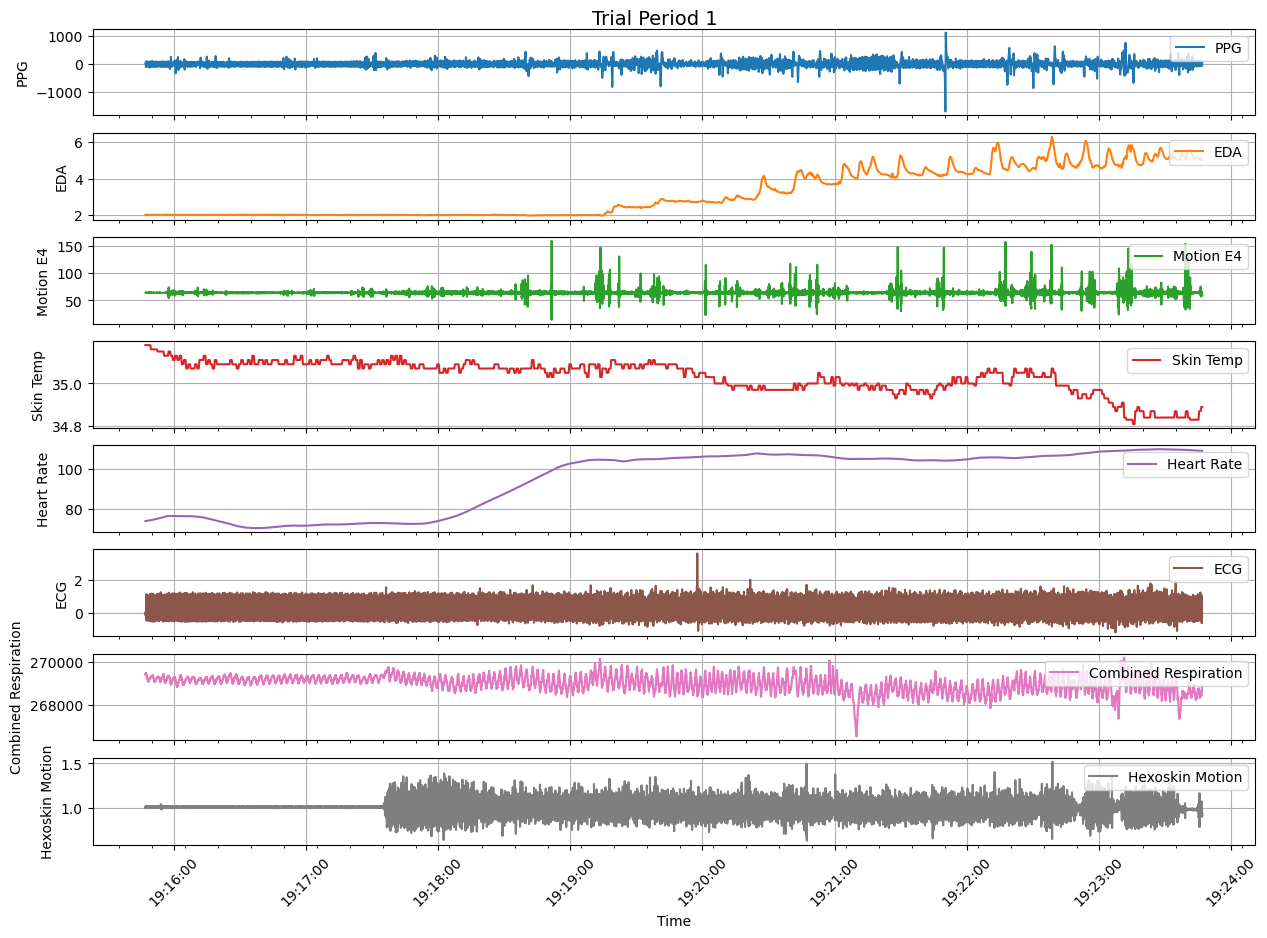

In [108]:

excluded_columns = [
    'E4 ACC X', 'E4 ACC Y', 'E4 ACC Z', 'ACC X', 'ACC Y', 'ACC Z',
    'Thoratic Respiration', 'Abdominal Respiration' 
]
#plot_signals(combined_df, 'baseline', time_periods, title="Baseline Period", exclude_columns=excluded_columns)
plot_signals(combined_df, 'trial_1', time_periods, title="Trial Period 1", exclude_columns=excluded_columns)
#plot_signals(combined_df, 'trial_2', time_periods, title="Trial Period 2", exclude_columns=excluded_columns)
excluded_columns = [
    'E4 ACC X', 'E4 ACC Y', 'E4 ACC Z', 'ACC X', 'ACC Y', 'ACC Z',
    'Thoratic Respiration', 'Abdominal Respiration' 
] # for later in the script. -AJS


## Pickling of The Synched Data

In [109]:
combined_df.to_pickle(os.path.join(dataDirectory, "synched_data.pkl"))
combined_raw_df.to_pickle(os.path.join(dataDirectory, "synched_data_raw.pkl"))
time_periods_df.to_pickle(os.path.join(dataDirectory,"event_times.pkl"))

In [110]:
def map_signals(signals_df, events_df):
    signals = signals_df.sort_index()  # Ensure signal data is sorted by timestamp
    events = events_df.sort_values(by="start")
    events["end"] = pd.to_datetime(events["end"])
    signals["event"] = "unknown"

    for _, event in events.iterrows():
        mask = (signals.index >= event["start"]) & (signals.index <= event["end"])
        signals.loc[mask, "event"] = event["name"]
    return signals


signals = map_signals(combined_df, time_periods_df)
signals.to_pickle(os.path.join(dataDirectory, 'labeled_signals.pkl'))

Well done! 
